In [21]:
import os
os.chdir("/home/yasser/classes/DL26/final_Project")


In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
import torch.nn.functional as F
import matplotlib.pyplot as plt
from src.utils.data_fetcher import create_loaders
from src.utils.SRESNET import SRResNet
from src.utils.helper_functions import train_sr, val_sr, plot_sr_progress
import os
import json

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device : {device}")

device : cuda


In [23]:
from src.utils.config import CONFIG
# CONFIG FROM YAML 
data_root      = CONFIG["paths"]["output_root"]
batch_size     = CONFIG["training"]["batch_size"]
num_workers    = CONFIG["training"]["num_workers"]
use_aug        = CONFIG["training"].get("use_augmentation", True)

# HYPERPARAMS FROM CONFIG 
lr              = CONFIG["training"]["lr"]
weight_decay    = CONFIG["training"]["weight_decay"]
step_size       = CONFIG["training"]["scheduler_step_size"]
gamma           = CONFIG["training"]["scheduler_gamma"]

In [24]:
train_loader, val_loader, test_loader = create_loaders("./data/preprocessed",batch_size=96)


📦 DATA LOADED:
  Train: 64800 samples
  Val:   8100 samples
  Test:  8100 samples


In [26]:
model = SRResNet().to(device)
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
scaler = None


In [16]:
"""
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

model.eval()

# ----------------------------------------------------
# TRANSFORMS
# ----------------------------------------------------
to_tensor = transforms.ToTensor()
to_pil = transforms.ToPILImage()

# ----------------------------------------------------
# PSNR
# ----------------------------------------------------
def compute_psnr(sr, hr, max_val=1.0):
    
    if sr.dim() == 3:
        sr = sr.unsqueeze(0)
    if hr.dim() == 3:
        hr = hr.unsqueeze(0)

    mse = torch.mean((sr - hr) ** 2)
    if mse == 0:
        return 100.0

    psnr = 10 * torch.log10((max_val ** 2) / mse)
    return psnr.item()

# ----------------------------------------------------
# LOAD IMAGE
# ----------------------------------------------------
def load_image(path):
    return Image.open(path).convert("RGB")

# ----------------------------------------------------
# BICUBIC UPSCALE
# ----------------------------------------------------
def bicubic_upscale(lr_img, scale=4):
    w, h = lr_img.size
    return lr_img.resize((w * scale, h * scale), Image.BICUBIC)

# ----------------------------------------------------
# SUPER RESOLUTION (SRResNet)
# ----------------------------------------------------
def run_srresnet(model, lr_img):
    lr_tensor = to_tensor(lr_img).unsqueeze(0).to(device)

    with torch.no_grad():
        sr_tensor = model(lr_tensor).clamp(0, 1)

    return to_pil(sr_tensor.squeeze(0).cpu())

# ----------------------------------------------------
# COMPARISON PIPELINE
# ----------------------------------------------------
def compare_images(lr_path, hr_path, scale=4):
    # Load LR and HR
    lr_img = load_image(lr_path)
    hr_img = load_image(hr_path)

    # Bicubic upscaled
    bic_img = bicubic_upscale(lr_img, scale)

    # SRResNet output
    sr_img = run_srresnet(model, lr_img)

    # ------------------------------------------------
    # PSNR COMPUTATION
    # ------------------------------------------------
    hr_tensor  = to_tensor(hr_img).to(device)
    bic_tensor = to_tensor(bic_img).to(device)
    sr_tensor  = to_tensor(sr_img).to(device)

    psnr_bic = compute_psnr(bic_tensor, hr_tensor)
    psnr_sr  = compute_psnr(sr_tensor, hr_tensor)

    print(f"📏 PSNR Bicubic x{scale}: {psnr_bic:.2f} dB")
    print(f"🚀 PSNR SRResNet x{scale}: {psnr_sr:.2f} dB")

    # ------------------------------------------------
    # SHOW RESULTS
    # ------------------------------------------------
    plt.figure(figsize=(18, 8))

    titles = [
        "Low-Resolution",
        f"Bicubic x{scale}\nPSNR: {psnr_bic:.2f} dB",
        f"SRResNet x{scale}\nPSNR: {psnr_sr:.2f} dB",
        "Ground Truth HR"
    ]

    images = [lr_img, bic_img, sr_img, hr_img]

    for i, (title, img) in enumerate(zip(titles, images)):
        plt.subplot(1, 4, i + 1)
        plt.imshow(img)
        plt.title(title)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

    # ------------------------------------------------
    # SAVE OUTPUTS
    # ------------------------------------------------
    lr_img.save("output_lr.png")
    bic_img.save("output_bicubic.png")
    sr_img.save("output_sr.png")
    print("Saved output images.")

    return lr_img, bic_img, sr_img, hr_img

# ----------------------------------------------------
# RUN TEST
# ----------------------------------------------------
compare_images(
    lr_path="./data/preprocessed/test/LR/austin1_r03_c02.png",
    hr_path="./data/preprocessed/test/HR/austin1_r03_c02.png"
)
"""

'\nimport torch\nfrom torchvision import transforms\nfrom PIL import Image\nimport matplotlib.pyplot as plt\n\nmodel.eval()\n\n# ----------------------------------------------------\n# TRANSFORMS\n# ----------------------------------------------------\nto_tensor = transforms.ToTensor()\nto_pil = transforms.ToPILImage()\n\n# ----------------------------------------------------\n# PSNR\n# ----------------------------------------------------\ndef compute_psnr(sr, hr, max_val=1.0):\n\n    if sr.dim() == 3:\n        sr = sr.unsqueeze(0)\n    if hr.dim() == 3:\n        hr = hr.unsqueeze(0)\n\n    mse = torch.mean((sr - hr) ** 2)\n    if mse == 0:\n        return 100.0\n\n    psnr = 10 * torch.log10((max_val ** 2) / mse)\n    return psnr.item()\n\n# ----------------------------------------------------\n# LOAD IMAGE\n# ----------------------------------------------------\ndef load_image(path):\n    return Image.open(path).convert("RGB")\n\n# ----------------------------------------------------

In [27]:
state_path = "src/models/checkpoints/SRESNET/training_state.json"
scheduler_path = "src/models/checkpoints/SRESNET/scheduler.pt"

history_path = "src/models/checkpoints/SRESNET/srresnet.json"

# ------------------ HISTORY ------------------
if os.path.exists(history_path):
    with open(history_path, "r") as f:
        history = json.load(f)
    print(f"✅ History loaded | {len(history['epoch'])} epochs found")
else:
    history = {
        "epoch": [],
        "train_loss": [],
        "val_loss": [],
        "train_psnr": [],
        "val_psnr": []
    }
    print("🆕 New history initialized")

start_epoch = history["epoch"][-1] + 1 if history["epoch"] else 1

# ------------------ TRAINING STATE ------------------
if os.path.exists(state_path):
    with open(state_path, "r") as f:
        state = json.load(f)
    best_psnr = state["best_psnr"]
    print(f"✅ Loaded best PSNR = {best_psnr:.2f} dB")
else:
    best_psnr = -float("inf")   # IMPORTANT
    print("🆕 No training state found, starting fresh")

print(f"➡️ Start epoch: {start_epoch}")
best_model_path = CONFIG["model"]["best_SRESNET_path"]

if os.path.exists(best_model_path):
    model.load_state_dict(torch.load(best_model_path, map_location=device))
    print("✅ Loaded best SRResNet model")
else:
    print("🚀 Training from scratch")

if os.path.exists(scheduler_path):
    scheduler.load_state_dict(torch.load(scheduler_path))
    print("✅ Scheduler state restored")
num_epochs = 2

for epoch in range(start_epoch, start_epoch + num_epochs):
    print(f"\nEpoch {epoch}")

    # -------- TRAIN --------
    train_loss, train_psnr, scaler = train_sr(
        model=model,
        train_loader=train_loader,
        loss_fn=criterion,
        optimizer=optimizer,
        device=device,
        scale_factor=4,
        model_requires_upscale=False,
        scheduler=scheduler,
        use_amp=True,
        scaler=scaler
    )

    # -------- VALIDATION --------
    val_loss, val_psnr = val_sr(
        model=model,
        val_loader=val_loader,
        loss_fn=criterion,
        device=device,
        scale_factor=4,
        model_requires_upscale=False
    )

    # -------- SAVE BEST MODEL + STATE --------
    if val_psnr > best_psnr:
        best_psnr = val_psnr

        torch.save(model.state_dict(), best_model_path)
        torch.save(scheduler.state_dict(), scheduler_path)

        with open(state_path, "w") as f:
            json.dump({"best_psnr": best_psnr}, f, indent=2)

        print(f"🏆 New best model saved | Val PSNR = {best_psnr:.2f} dB")

    # -------- SAVE METRICS --------
    history["epoch"].append(epoch)
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_psnr"].append(train_psnr)
    history["val_psnr"].append(val_psnr)

    with open(history_path, "w") as f:
        json.dump(history, f, indent=2)

    # -------- LOG --------
    print(f"Train loss: {train_loss:.6f} | Train PSNR: {train_psnr:.2f} dB")
    print(f"Val   loss: {val_loss:.6f} | Val   PSNR: {val_psnr:.2f} dB")
    print(f"→ Current LR: {optimizer.param_groups[0]['lr']:.8f}")


/tmp/ipykernel_572728/1245913516.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path, map_location=device))


✅ History loaded | 32 epochs found
🆕 No training state found, starting fresh
➡️ Start epoch: 33
✅ Loaded best SRResNet model

Epoch 33


Training:   0%|          | 0/675 [00:00<?, ?it/s]

🏆 New best model saved | Val PSNR = 27.54 dB
Train loss: 0.031311 | Train PSNR: 25.73 dB
Val   loss: 0.028280 | Val   PSNR: 27.54 dB
→ Current LR: 0.00010000

Epoch 34


Train loss: 0.031180 | Train PSNR: 25.76 dB
Val   loss: 0.028223 | Val   PSNR: 27.54 dB
→ Current LR: 0.00010000


In [10]:
"""
import json
import os

history_path = "src/models/checkpoints/SRESNET/srresnet.json"

if os.path.exists(history_path):
    with open(history_path, "r") as f:
        history = json.load(f)
    print(f"✅ History loaded | {len(history['epoch'])} epochs found")
else:
    history = {
        "epoch": [],
        "train_loss": [],
        "val_loss": [],
        "train_psnr": [],
        "val_psnr": []
    }
    print("🆕 New history initialized")
start_epoch = history["epoch"][-1] + 1 if history["epoch"] else 1
print(start_epoch)

best_model_path = CONFIG["model"]["best_SRESNET_path"]
best_psnr = 0.0

if os.path.exists(best_model_path):
    model.load_state_dict(torch.load(best_model_path, map_location=device))
    print("✅ Loaded best SRResNet model")

else:
    print("🚀 Training from scratch")
    history = {
        "epoch": [],
        "train_loss": [],
        "val_loss": [],
        "train_psnr": [],
        "val_psnr": []
    }
    start_epoch = 0

num_epochs = 2

for epoch in range(start_epoch, start_epoch + num_epochs):
    print(f"\nEpoch {epoch}")

    # -------- TRAIN --------
    train_loss, train_psnr, scaler = train_sr(
        model=model,
        train_loader=train_loader,
        loss_fn=criterion,
        optimizer=optimizer,
        device=device,
        scale_factor=4,
        model_requires_upscale=False,
        scheduler=scheduler,
        use_amp=True,
        scaler=scaler
    )

    # -------- VALIDATION --------
    val_loss, val_psnr = val_sr(
        model=model,
        val_loader=val_loader,
        loss_fn=criterion,
        device=device,
        scale_factor=4,
        model_requires_upscale=False
    )

    # -------- SAVE BEST MODEL --------
    if val_psnr > best_psnr:
        best_psnr = val_psnr
        torch.save(model.state_dict(), best_model_path)
        print(f"🏆 New best model saved | Val PSNR = {best_psnr:.2f} dB")

    # -------- SAVE METRICS --------
    history["epoch"].append(epoch)
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_psnr"].append(train_psnr)
    history["val_psnr"].append(val_psnr)

    with open(history_path, "w") as f:
        json.dump(history, f, indent=2)

    # -------- LOG --------
    print(f"Train loss: {train_loss:.6f} | Train PSNR: {train_psnr:.2f} dB")
    print(f"Val   loss: {val_loss:.6f} | Val   PSNR: {val_psnr:.2f} dB")
    print(f"→ Current LR: {optimizer.param_groups[0]['lr']:.8f}")
"""

/tmp/ipykernel_572728/2740316606.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path, map_location=device))


✅ Loaded best SRResNet model

Epoch 31


Training:   0%|          | 0/675 [00:00<?, ?it/s]

🏆 New best model saved | Val PSNR = 27.41 dB
Train loss: 0.031448 | Train PSNR: 25.70 dB
Val   loss: 0.028808 | Val   PSNR: 27.41 dB
→ Current LR: 0.00010000

Epoch 32


🏆 New best model saved | Val PSNR = 27.47 dB
Train loss: 0.031331 | Train PSNR: 25.73 dB
Val   loss: 0.028617 | Val   PSNR: 27.47 dB
→ Current LR: 0.00010000


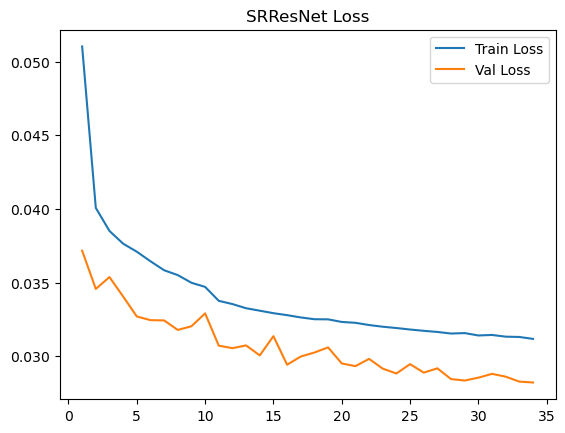

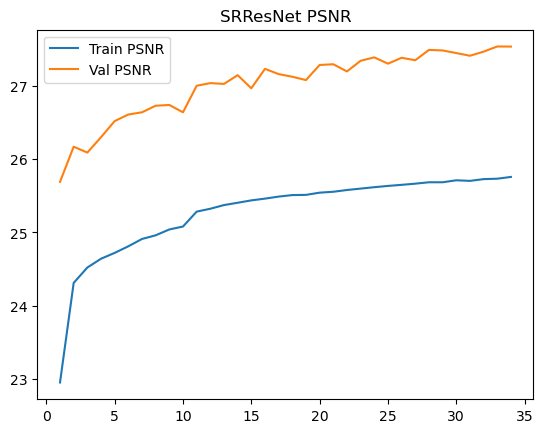

In [28]:
import matplotlib.pyplot as plt

epochs = history["epoch"]

plt.figure()
plt.plot(epochs, history["train_loss"], label="Train Loss")
plt.plot(epochs, history["val_loss"], label="Val Loss")
plt.legend()
plt.title("SRResNet Loss")
plt.show()

plt.figure()
plt.plot(epochs, history["train_psnr"], label="Train PSNR")
plt.plot(epochs, history["val_psnr"], label="Val PSNR")
plt.legend()
plt.title("SRResNet PSNR")
plt.show()


In [ ]:
print(history)

{'epoch': [], 'train_loss': [], 'val_loss': [], 'train_psnr': [], 'val_psnr': []}


In [20]:
best_psnr = -float("inf")
print(best_psnr)

-inf
